# Проект №4. RDS. Кредитный рейтинг.

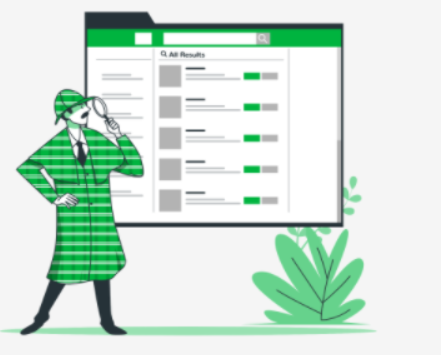

### Задача: построить модель кредитного скоринга для вторичных клиентов

In [791]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split # функция, чтобы разбить данные на трейн и тест

from sklearn.linear_model import LogisticRegression # наша модель для классификации

from sklearn.preprocessing import PolynomialFeatures #для создания полиномиальных признаков

import re
import datetime
from datetime import datetime, timedelta
from itertools import combinations #для теста Стьюдента
from scipy.stats import ttest_ind #для теста Стьюдента
from sklearn.preprocessing import StandardScaler #для std нормализации Стандартизация числовых переменных
from sklearn.preprocessing import MinMaxScaler #для minmax нормализации
from textblob import TextBlob

import warnings; warnings.simplefilter('ignore')
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


        # Any results you write to the current directory are saved as output.

In [792]:
#с учебной страницы курса
from pandas import Series
import pandas as pd #есть
import numpy as np #есть


import matplotlib.pyplot as plt #есть
import seaborn as sns #есть

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, log_loss #дополнила log_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve #метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #метрики

from sklearn.model_selection import GridSearchCV #для гиперпараметров


In [793]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [794]:
# тренировочный (train, используется для обучения модели)
df_train = pd.read_csv('train.csv')

# тестовый (test, используется для оценки точности модели)
df_test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

In [795]:
!pip freeze > requirements.txt

"pip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [796]:
#Функция для анализа числовых столбцов
def func_(df, col, with_bins):
    
    #Заменим на NaN если есть пустая строчка     
    df[col] = df[col].apply(lambda x: None if str(x).strip()=='' else x)
    
    #display(pd.DataFrame(df[col].value_counts()))
    print("Значений, встретившихся в столбце", col, "более 10 раз:", (df[col].value_counts()>10).sum())
    print("Уникальных значений:", df[col].nunique())
    df.loc[:, [col]].info()
    
    if with_bins == 1:
    
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])
        axes.hist(df[col], bins = int(df[col].median()),color = 'green') 
        #axes.set_title('Общая сумма счета')
        axes.set_ylabel('Количество')
        axes.set_xlabel(col)  
        
    else: # без bins равному медиане
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])
        axes.hist(df[col], color = 'green')        
        axes.set_ylabel('Количество')
        axes.set_xlabel(col) 

In [797]:
#Функция для анализа квантилей и выбросов
def func_quantile(df, col):   
    
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    # Подсчитаем количество выбросов
    print("Количество выбросов в столбце",col,":",df[df[col]<perc25 - 1.5*IQR][col].count() + df[df[col]>perc75 + 1.5*IQR][col].count())
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend()  

In [798]:
#Функция для заполнения выбросов ближайшим квантилем
def filling_quantile(df, col, change_quant): #quant=0.25 или 0.75
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    high_border = perc75 + 1.5*IQR
    low_border = perc25 - 1.5*IQR
    if change_quant == 0.75:
        df[col] = df[col].apply(lambda x: high_border if x>high_border else x)
    elif change_quant == 0.25:
        df[col] = df[col].apply(lambda x: low_border if x<low_border else x)
    else:
        print('Значение квантиля должно быть 0.25 или 0.75 :)')

In [799]:
#Строим график для колонок, содержащих номинативные переменные
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(x=column, y='default', 
                data=df_clients.loc[df_clients.loc[:, column].isin(df_clients.loc[:, column].value_counts().index[:20])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [800]:
def get_stat_dif(column):
    cols = df_clients.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_clients.loc[df_clients.loc[:, column] == comb[0], 'default'], 
                        df_clients.loc[df_clients.loc[:, column] == comb[1], 'default']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
        else:
            return column
            break

In [801]:
# Считаем метрики модели
def metrics(y_test, probs, y_pred_test):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.rcParams['figure.figsize'] = (8,8)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1_test_n = f1_score(y_test, y_pred_test)
    print('f1 score:=',round(f1_test_n,4))

    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    print('precision: {:.4f}\nrecall: {:.4f}'.format(precision, recall))

    #calc_accuracy(y_test, y_pred_test)
    #acc, TP, TN, P, N = calc_accuracy(y_test, y_pred_test)
    #print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {:.4f}'.format(TP, TN, P, N, acc))

    conf_mat = confusion_matrix(y_test, y_pred_test)
    print('Confusion matrix:\n{}'.format(conf_mat))
  #  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
  #  disp.plot()

In [802]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [803]:
df_train.head(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
5,41415,18FEB2014,SCH,M,27,Y,N,0,1,-2.032257,0,50,1,1,15000,2,3,N,0
6,28436,04FEB2014,SCH,M,39,N,N,0,0,-2.225004,0,60,1,2,28000,1,1,N,0
7,68769,17MAR2014,SCH,F,39,N,N,0,0,-1.522739,1,50,2,3,45000,3,3,N,0
8,38424,14FEB2014,SCH,F,50,Y,N,1,0,-1.676061,0,50,1,1,30000,1,4,N,0
9,4496,10JAN2014,UGR,F,54,N,N,0,0,-2.695176,1,50,2,3,24000,1,3,N,0


In [804]:
df_train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [805]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [806]:
# Для корректной обработки данных объединим train и test в один датасет
df_train['sample'] = 1 # помечаем train
df_test['sample'] = 0 # помечаем test
df_test['default'] = 0 # # в тесте у нас нет значения дефолта, мы его должны предсказать, по этому пока просто заполняем нулями

df_clients = df_test.append(df_train, sort=False).reset_index(drop=True)

In [807]:
df_clients.default.value_counts()

0    100776
1      9372
Name: default, dtype: int64

In [808]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [809]:
df_clients.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [810]:
#посмотрим наглядно пустые строки
#уберу пока, чтоб ресурсы не ел
#fig, ax = plt.subplots(figsize=(8,8))
#sns_heatmap = sns.heatmap(df_clients.isnull(), cbar=False)

In [811]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)
#pip install pandas-profiling[pandas_profiling-3.0.0-py2.py3-none-any]

In [812]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [813]:
#ERROR: Failed building wheel for bottleneck
#ERROR: Could not build wheels for bottleneck which use PEP 517 and cannot be installed directly
#WARNING: You are using pip version 20.1.1; however, version 21.2.1 is available.
#You should consider upgrading via the 'c:\users\valer\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.
#'c:\users\valer\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.

Посмотрим на данные:

In [814]:
df_clients.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default'],
      dtype='object')

- client_id	- идентификатор клиента
- education	- уровень образования
- sex	- пол заёмщика
- age	- возраст заёмщика
- car	- флаг наличия автомобиля
- car_type	- флаг автомобиля-иномарки
- decline_app_cnt -	количество отказанных прошлых заявок
- good_work	- флаг наличия «хорошей» работы
- bki_request_cnt -	количество запросов в БКИ
- home_address -	категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income -	доход заёмщика
- foreign_passport -	наличие загранпаспорта
- default -	наличие дефолта

<AxesSubplot:>

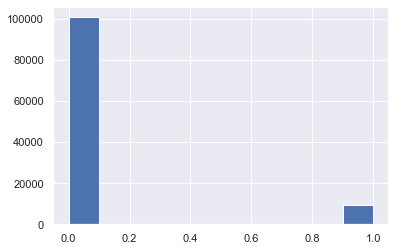

In [815]:
#Построим диаграмму для переменной default. Клиентов без дефолта у банка больше.
df_clients.default.hist()

In [816]:
df_clients.default.value_counts()

0    100776
1      9372
Name: default, dtype: int64

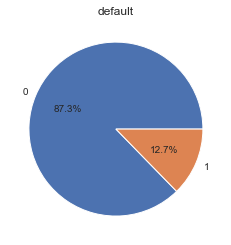

In [817]:
plt.pie(x=df_train['default'].value_counts(),
       labels=list(df_train['default'].value_counts().index),
       autopct='%.1f%%',
       textprops={'fontsize': 10})
plt.title('default')
plt.show()

In [818]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [819]:
#посмотрим количество пропусков для каждого признака:
df_clients.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.

In [820]:
#бинарные переменные
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#категориальные переменные
cat_cols=['education','home_address','work_address','app_date','sna'] 

#числовые переменные
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating','first_time']

### Создадим наивную модель

In [821]:
df_clients_copy = df_clients.copy()

In [822]:
df_clients_copy.dropna(inplace=True)

In [823]:
#Попробуем сделать дамми-перемнные для категориальных переменных
df_clients_copy = pd.get_dummies(df_clients_copy, columns=['sex','car_type','foreign_passport'], dummy_na=False)

In [824]:
train_df = df_clients_copy.drop(['client_id','home_address','work_address','education','car','app_date'], axis=1)
X = train_df.drop(['default'], axis=1)
y = train_df['default'].values # Наша целевая переменная

In [825]:
df_clients_copy.head()

,client_id,app_date,education,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,sna,first_time,sample,default,sex_F,sex_M,car_type_N,car_type_Y,foreign_passport_N,foreign_passport_Y
0,74835,22MAR2014,GRD,29,Y,0,0,-2.271884,3,50,...,1,4,0,0,0,1,0,1,1,0
1,17527,24JAN2014,SCH,39,N,5,0,-1.504999,2,50,...,4,3,0,0,1,0,1,0,1,0
2,75683,23MAR2014,UGR,50,Y,0,0,-1.691339,1,50,...,1,3,0,0,0,1,0,1,0,1
3,26883,03FEB2014,SCH,56,N,0,0,-2.374182,1,40,...,1,3,0,0,0,1,1,0,1,0
4,28862,04FEB2014,GRD,38,N,0,0,-2.487502,0,80,...,1,3,0,0,1,0,1,0,1,0


In [826]:
#Разбиваем выборку на обучающую и тестовую и обучаем нашу модель:
X_train, X_val, y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42) 
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [827]:
#Готово! Теперь осталось только вычислить необходимые метрики:

Y_predicted = model.predict(X_val)
probs = model.predict_proba(X_val)
probs = probs[:,1]

print('roc_auc_score:', roc_auc_score(Y_val, Y_predicted))
print("accuracy_score:",accuracy_score(Y_val,Y_predicted)) #метрика accuracy - количество верно определенных объектов на общее количество объектов
print("precision_score:",precision_score(Y_val,Y_predicted)) #метрика precision точность
print("recall_score:",recall_score(Y_val,Y_predicted)) #метрика recall полнота
print("f1_score:",f1_score(Y_val,Y_predicted)) #метрика, которая объединяет в себе сразу и точность, и полноту F-мера

roc_auc_score: 0.5
accuracy_score: 0.9155192851281116
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0


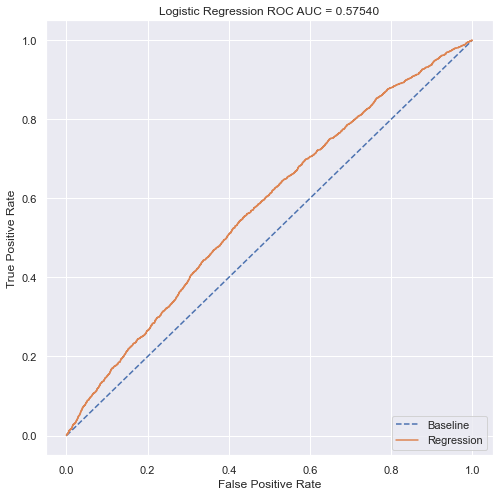

f1 score:= 0.0
precision: 0.0000
recall: 0.0000
Confusion matrix:
[[20081     0]
 [ 1853     0]]


In [828]:
metrics(Y_val, probs, Y_predicted)

In [829]:
log_loss(Y_val,Y_predicted)

2.917860520642359

## Рассмотрим и проанализируем числовые переменные в колонках num_cols

In [830]:
#num_cols содержит -> num_cols=['age','decline_app_cnt','income','bki_request_cnt']

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

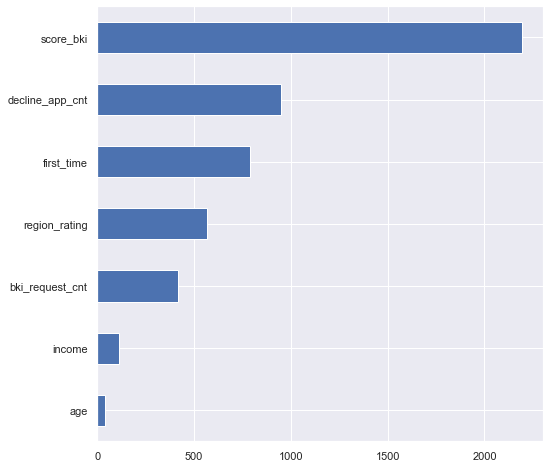

In [831]:
imp_num = pd.Series(f_classif(df_clients[num_cols], df_clients['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Вывод: Самый значимый признак из числовых признаков - <b>score_bki</b>

In [832]:
#Посмотрим на распределение числовых данных:

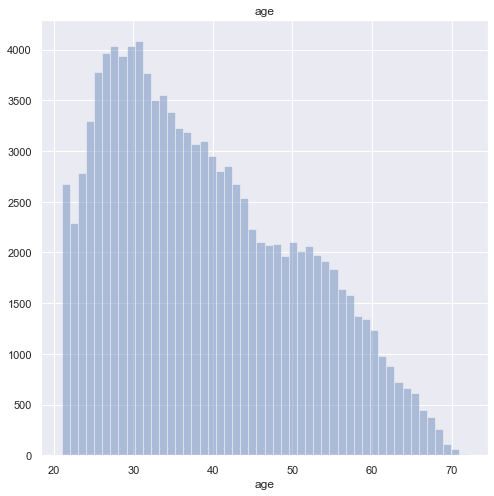

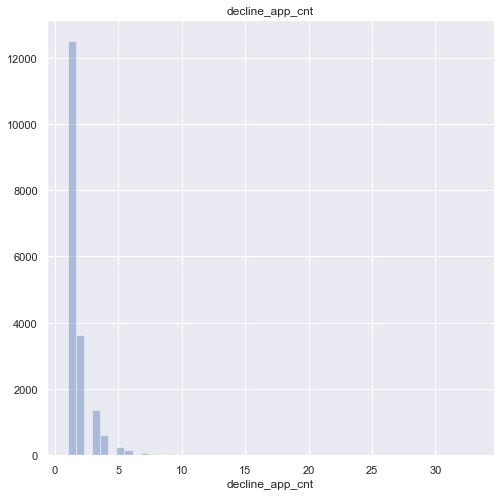

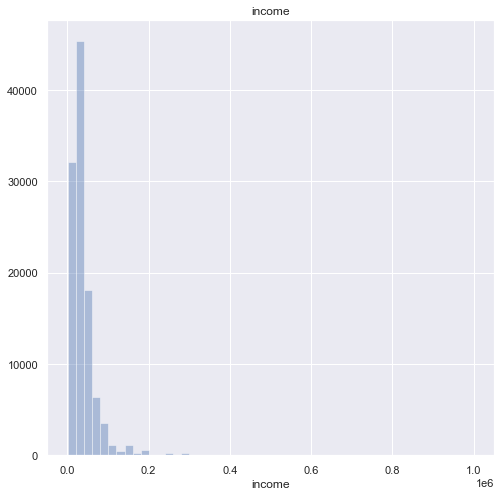

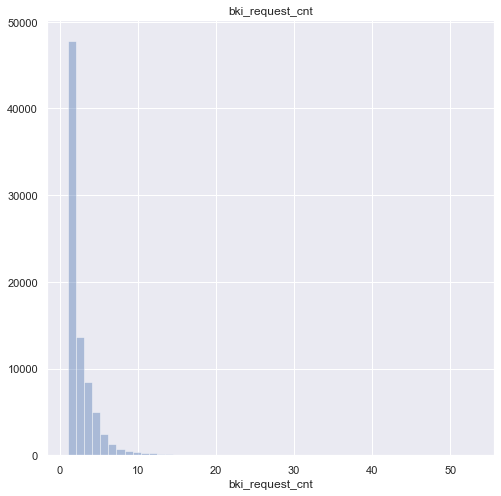

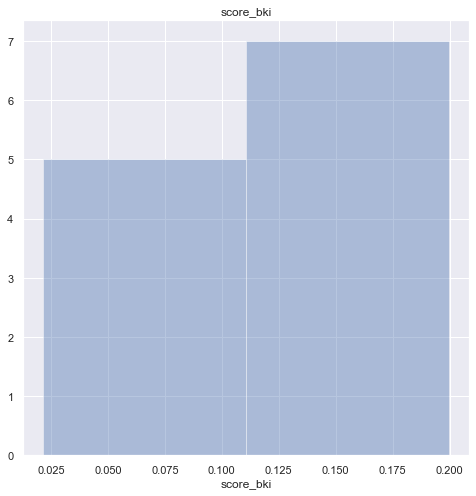

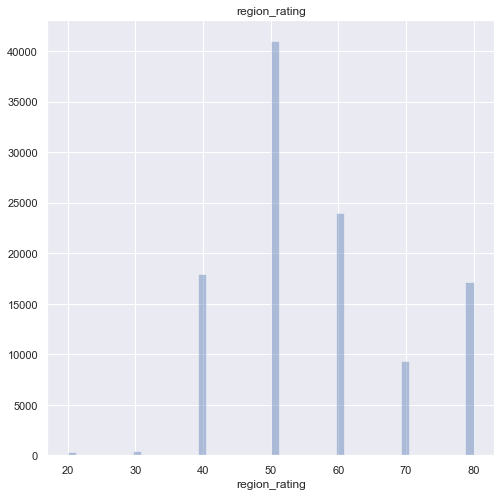

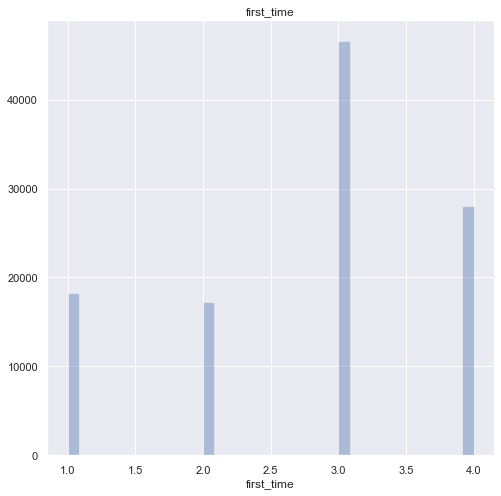

In [833]:
for i in num_cols:
    plt.figure()
    sns.distplot(df_clients[i][df_clients[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [834]:
#После построения гистограмм стало очевидно, что распределения всех числовых переменных имеют тяжёлый правый хвост. 
#Пройдемся по каждой колонке более детально

### Рассмотрим и проанализируем колонку age

Значений, встретившихся в столбце age более 10 раз: 50
Уникальных значений: 52
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   age     110148 non-null  int64
dtypes: int64(1)
memory usage: 860.6 KB


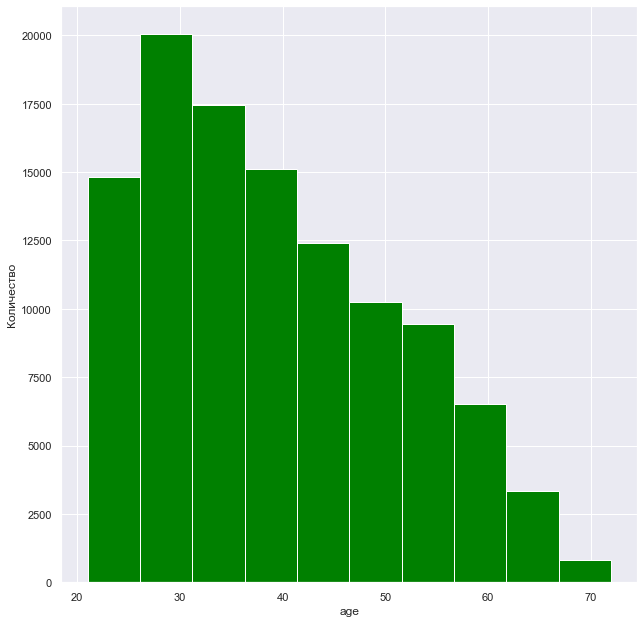

In [835]:
func_(df_clients,'age',10)

Распределение не являются нормальными и смещено вправо. 
При построении модели необходимо будет выполнить стандартизацию этого численного признака.

25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Количество выбросов в столбце age : 0


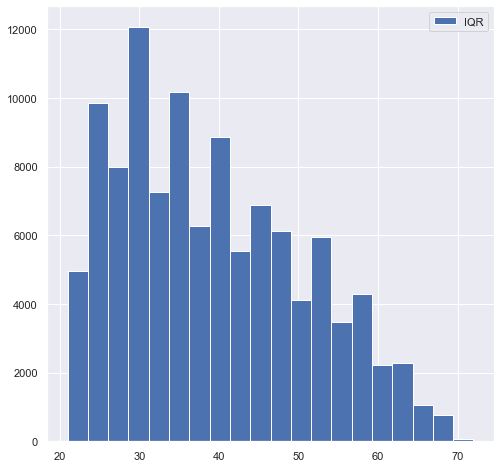

In [836]:
func_quantile(df_clients,'age')

<AxesSubplot:xlabel='age'>

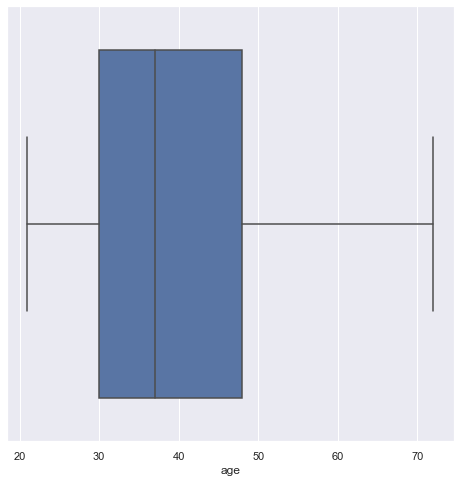

In [837]:

sns.boxplot(x= 'age', data = df_clients)

<AxesSubplot:xlabel='age'>

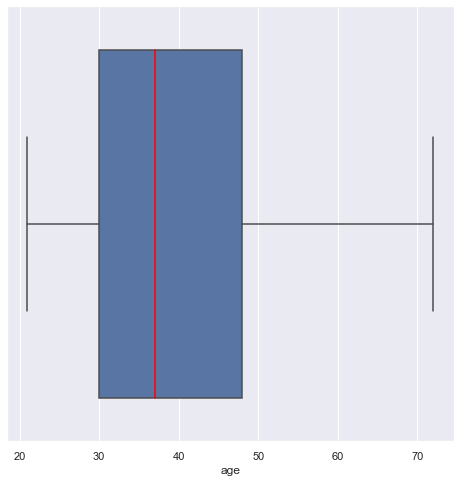

In [838]:
#удобно различать медианы
sns.boxplot(x=df_clients['age'], medianprops={'color':'red'})

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

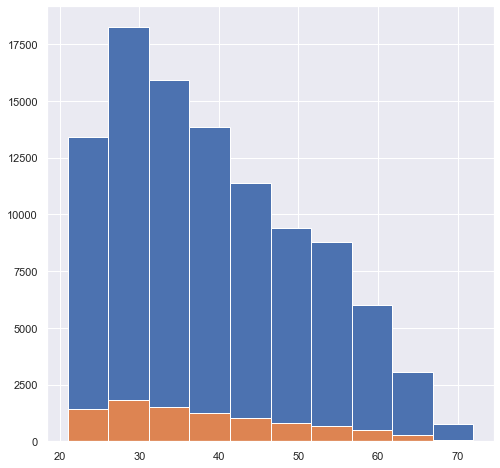

In [839]:
df_clients.groupby('default')['age'].hist()

<AxesSubplot:xlabel='default'>

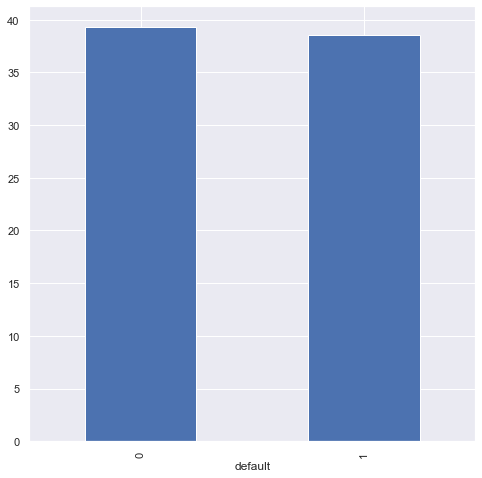

In [840]:
df_clients.groupby(by = ['default'])['age'].mean().plot(kind = 'bar', grid= True)

<AxesSubplot:xlabel='default'>

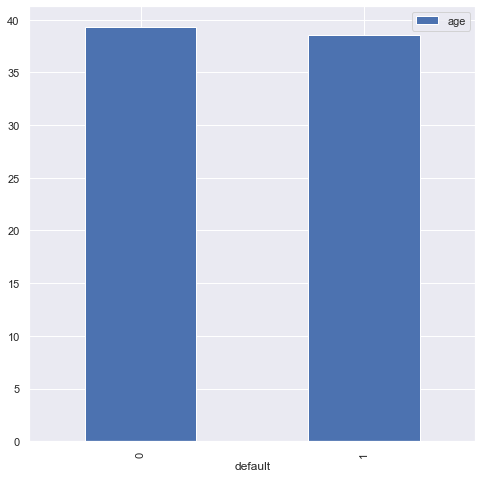

In [841]:
df_clients.pivot_table(values = ['age'], 
               index = 'default', 
               aggfunc = 'mean').plot(kind = 'bar')

In [842]:
df_clients.groupby(by = ['default'])['age'].median()

default
0    37
1    36
Name: age, dtype: int64

Дефолтные клиенты в среднем младше, но незначительно

In [843]:
#Посмотрим на корреляцию
df_clients.loc[:,'default'].astype('float64').corr(df_clients.loc[:,'age']).astype('float64')

-0.019169365430152713

Корреляция небольшая.

In [844]:
def func(x):
    if x > 30 and x < 48:
        return 1
    else: return 0     

In [845]:
df_clients['age_group'] = df_clients['age'].apply(func)

In [846]:
#Посмотрим на корреляцию
df_clients.loc[:,'default'].astype('float64').corr(df_clients.loc[:,'age_group']).astype('float64')

-0.0023946149706350083

In [847]:
#Корреляция стала еще меньше. Удалим 'age_group'
df_clients = df_clients.drop(['age_group'], axis=1)

In [848]:
# Нормализуем признак
a_features = df_clients[['age']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
df_clients.loc[:, ['age']] = norm_features

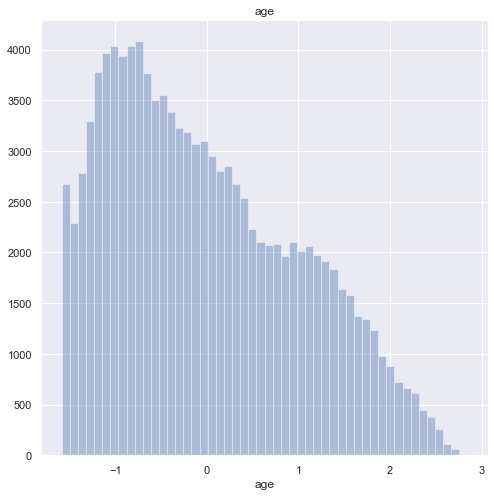

In [849]:
#Проверим, что получилось
plt.figure()
sns.distplot(df_clients['age'], kde = False, rug=False)
plt.title('age')
plt.show()

### Рассмотрим и проанализируем колонку decline_app_cnt

In [850]:
#decline_app_cnt - количество отказанных прошлых заявок

Значений, встретившихся в столбце decline_app_cnt более 10 раз: 11
Уникальных значений: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   decline_app_cnt  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.6 KB


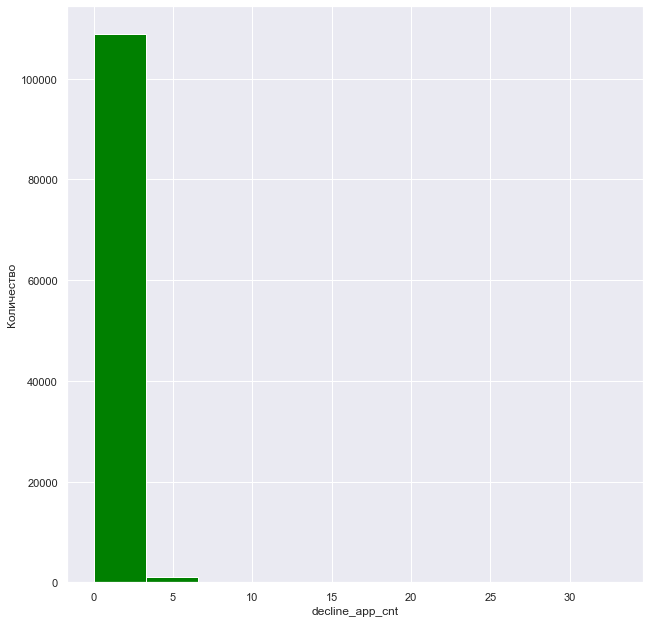

In [851]:
func_(df_clients,'decline_app_cnt',10)

<AxesSubplot:xlabel='default'>

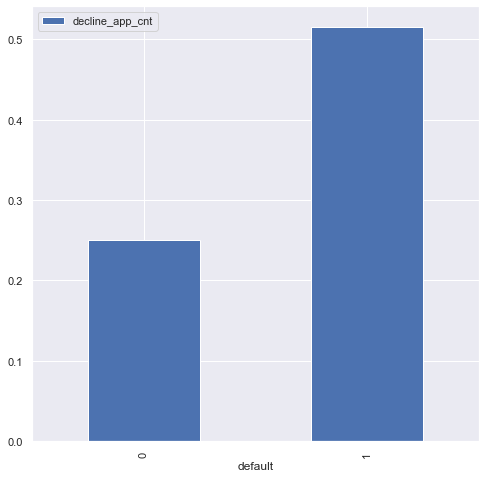

In [852]:
df_clients.pivot_table(values = ['decline_app_cnt'], 
               index = 'default', 
               aggfunc = 'mean').plot(kind = 'bar')

In [853]:
df_clients.groupby('default')['decline_app_cnt'].mean()

default
0    0.250675
1    0.515472
Name: decline_app_cnt, dtype: float64

Дефолтные клиенты в среднем имеют большое количество отмененных заявок

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Количество выбросов в столбце decline_app_cnt : 18677


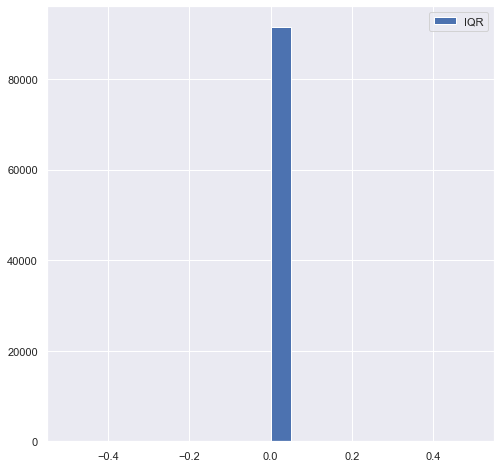

In [854]:
func_quantile(df_clients,'decline_app_cnt')

<AxesSubplot:xlabel='decline_app_cnt'>

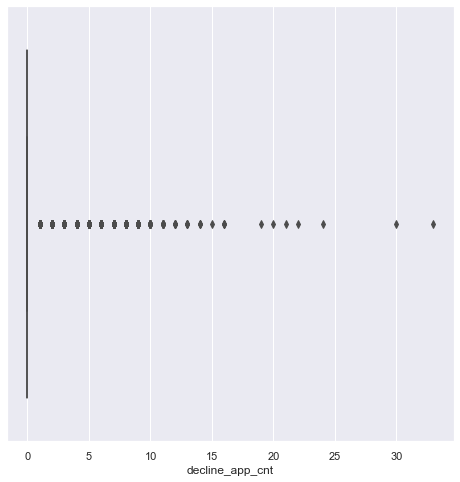

In [855]:
sns.boxplot(x= 'decline_app_cnt', data = df_clients)

In [856]:
filling_quantile(df_clients, 'decline_app_cnt', 0.25)

In [857]:
#Посмотрим на корреляцию
df_clients.loc[:,'default'].astype('float64').corr(df_clients.loc[:,'decline_app_cnt']).astype('float64')

0.0924553642033095

In [858]:
# Нормализуем
#a_features = df_clients[['decline_app_cnt']].values
#norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
#df_clients.loc[:, ['decline_app_cnt']] = norm_features

#Проверим, что получилось
#plt.figure()
#sns.distplot(df_clients['decline_app_cnt'], kde = False, rug=False)
#plt.title('decline_app_cnt')
#plt.show()

In [859]:
#Попробуем нормализацию MinMaxScaler
scaler = MinMaxScaler()
Ranking_norm = scaler.fit_transform(df_clients.loc[:,['decline_app_cnt']]) 
df_clients.loc[:, ['decline_app_cnt']] = Ranking_norm

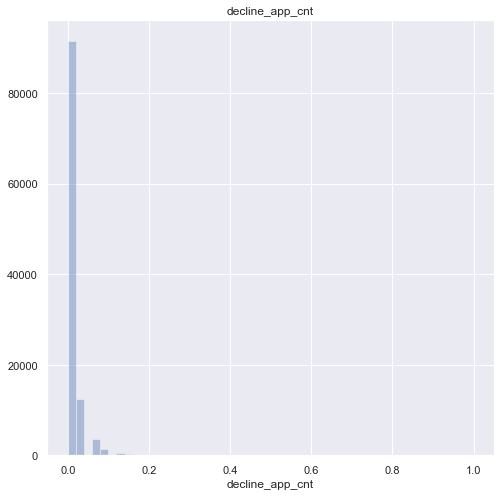

In [860]:
#Проверим, что получилось
plt.figure()
sns.distplot(df_clients['decline_app_cnt'], kde = False, rug=False)
plt.title('decline_app_cnt')
plt.show()

In [861]:
#еще прологарифмируем признак для выравнивания распределения
#y_new = np.log(y + 1)
# убрала пока df_clients['decline_app_cnt'] = np.log(df_clients['decline_app_cnt']+1)

Text(0.5, 0, 'decline_app_cnt')

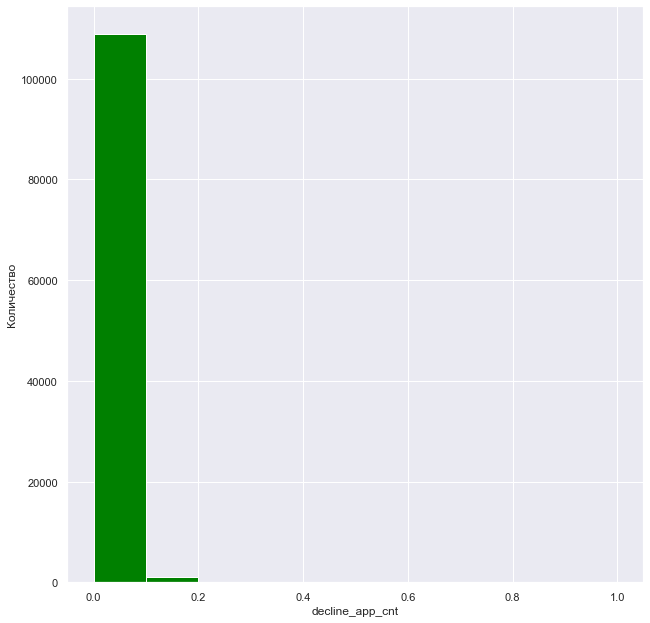

In [862]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df_clients['decline_app_cnt'], color = 'green')        
axes.set_ylabel('Количество')
axes.set_xlabel('decline_app_cnt') 

### Рассмотрим и проанализируем колонку income

In [863]:
#income - доход заёмщика

Значений, встретившихся в столбце income более 10 раз: 218
Уникальных значений: 1207
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   income  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.6 KB


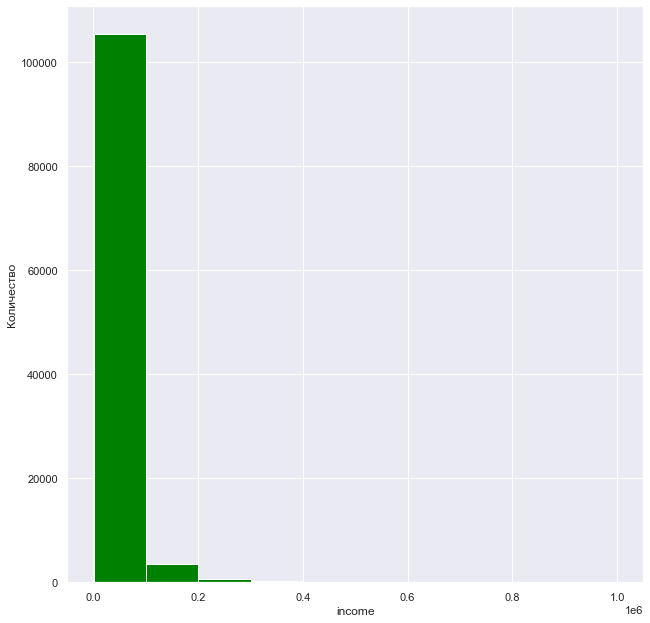

In [864]:
func_(df_clients,'income',10)

In [865]:
df_clients.groupby('default')['income'].mean()

default
0    41452.022436
1    36288.113316
Name: income, dtype: float64

Дефолтные клиенты в среднем имеют более низкий доход

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Количество выбросов в столбце income : 7000


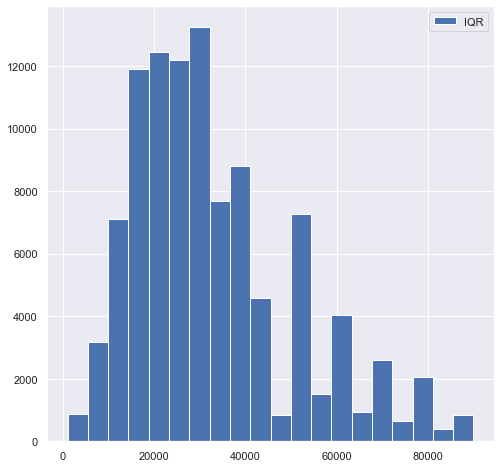

In [866]:
func_quantile(df_clients,'income')

In [867]:
#Заменим выбросы ближайшим квантилем
filling_quantile(df_clients,'income', 0.75)

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Количество выбросов в столбце income : 0


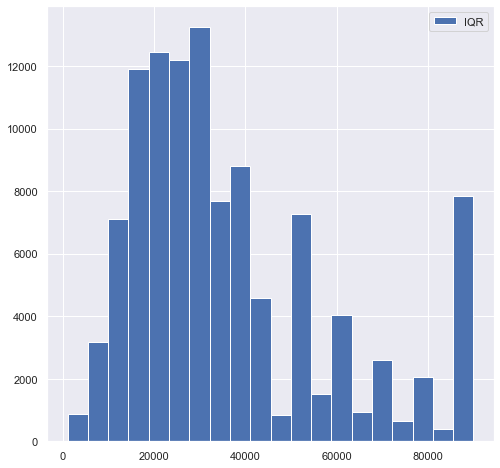

In [868]:
func_quantile(df_clients,'income')

In [869]:
#Попробуем нормализацию MinMaxScaler
scaler = MinMaxScaler()
income_norm = scaler.fit_transform(df_clients.loc[:,['income']]) 
df_clients.loc[:, ['income']] = income_norm

Text(0.5, 0, 'income')

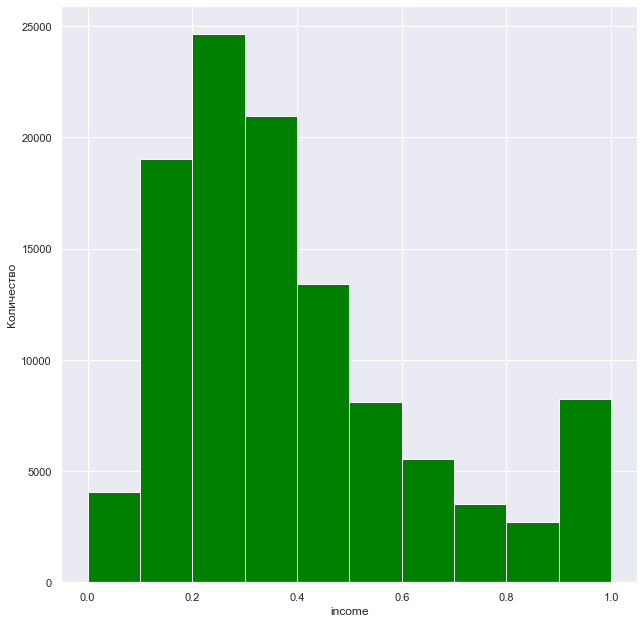

In [870]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df_clients['income'], color = 'green')        
axes.set_ylabel('Количество')
axes.set_xlabel('income') 

Распределение стало больше похоже на нормальное

In [871]:
#Посмотрим на корреляцию
df_clients.loc[:,'default'].astype('float64').corr(df_clients.loc[:,'income']).astype('float64')

-0.04851463539428155

Корреляция слабая

### Рассмотрим и проанализируем колонку bki_request_cnt

In [872]:
#bki_request_cnt - количество запросов в БКИ

Значений, встретившихся в столбце bki_request_cnt более 10 раз: 24
Уникальных значений: 40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   bki_request_cnt  110148 non-null  int64
dtypes: int64(1)
memory usage: 860.6 KB


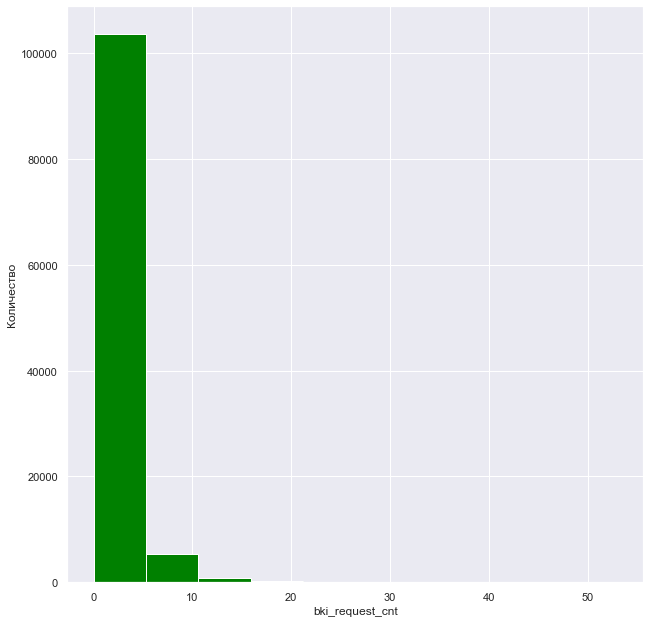

In [873]:
func_(df_clients,'bki_request_cnt',10)

{Преобразование целевого признака выполнялось так
y_new = np.log(y + 1)
Значит обратное преобразование будет таким
y = np.exp(y_new) - 1}

<AxesSubplot:xlabel='default'>

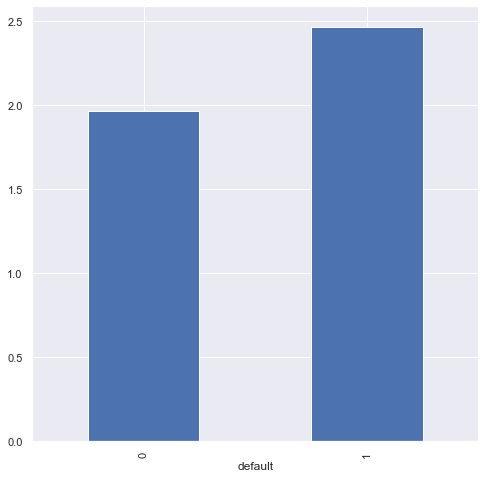

In [874]:
df_clients.groupby(by = ['default'])['bki_request_cnt'].mean().plot(kind = 'bar', grid= True)

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Количество выбросов в столбце bki_request_cnt : 2636


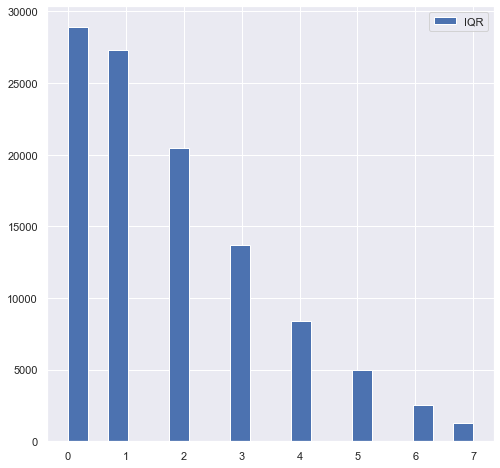

In [875]:
func_quantile(df_clients,'bki_request_cnt')

In [876]:
#Заменим выбросы ближайшим квантилем
filling_quantile(df_clients,'bki_request_cnt', 0.75)

У нашего распределения есть проблема — слишком сильный перепад. На практике часто в таких случаях логарифмируют переменную, чтобы уменьшить перепады и сгладить хвост.

Логарифмирование на практике не дало сильного улучшения модели. Убрала.

In [877]:
# убрала пока df_clients['bki_request_cnt'] = df_clients['bki_request_cnt'].apply(lambda w: np.log(w + 1))
#df_clients.bki_request_cnt.hist();

<AxesSubplot:>

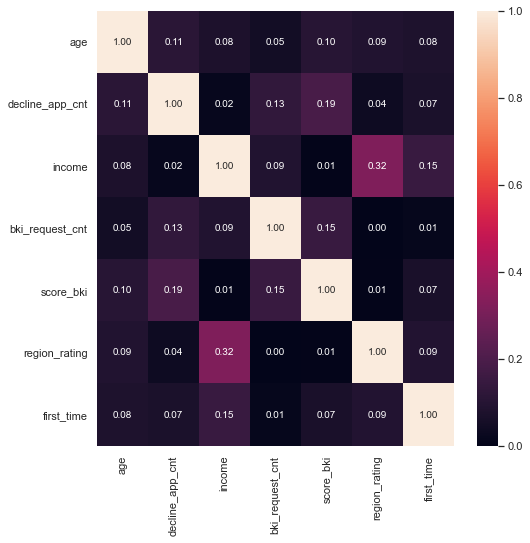

In [878]:
sns.heatmap(df_clients[num_cols].corr().abs(), vmin=0, vmax=1,annot=True, fmt=".2f",)

<AxesSubplot:>

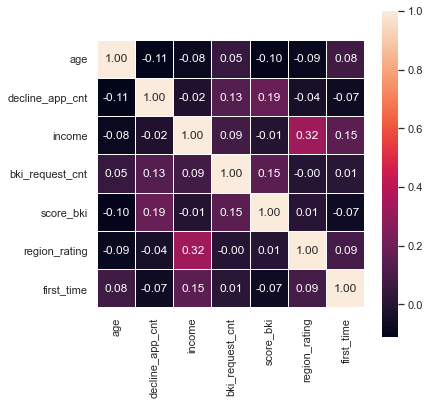

In [879]:
sns.set(font_scale=1)
plt.subplots(figsize=(6, 6))
sns.heatmap(df_clients[num_cols].corr(), square=True,
              annot=True, fmt=".2f", linewidths=0.1 )

Как мы видим, взаимосвязь пар числовых признаков по Пирсону слабая. Максимальный коэффициент -0.11 и 0.11. Это очень здорово для нашей модели.

In [880]:
df_clients.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,-0.889859,Y,Y,0.000000,0,-2.271884,3.0,50,1,2,0.550562,1,4,N,0,0
1,17527,24JAN2014,SCH,F,-0.021654,N,N,0.151515,0,-1.504999,2.0,50,1,2,0.044944,4,3,N,0,0
2,75683,23MAR2014,UGR,M,0.933372,Y,Y,0.000000,0,-1.691339,1.0,50,1,2,0.325843,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,1.454295,N,N,0.000000,0,-2.374182,1.0,40,1,2,0.179775,1,3,N,0,0
4,28862,04FEB2014,GRD,F,-0.108474,N,N,0.000000,0,-2.487502,0.0,80,2,3,1.000000,1,3,N,0,0


## Рассмотрим и проанализируем категориальные переменные в колонках cat_cols

In [881]:
#категориальные переменные
#cat_cols=['education','home_address','work_address','sna']

### Рассмотрим и проанализируем колонку app_date

In [882]:
#app_date- дата подачи заявки 
#Преобразуем дату 
df_clients['app_date'] = pd.to_datetime(df_clients['app_date'])
df_clients['app_date'] = df_clients['app_date'].apply(lambda x: x.month)

#добавим после преобразования эту колонку в num_cols
num_cols.append('app_date')

<AxesSubplot:>

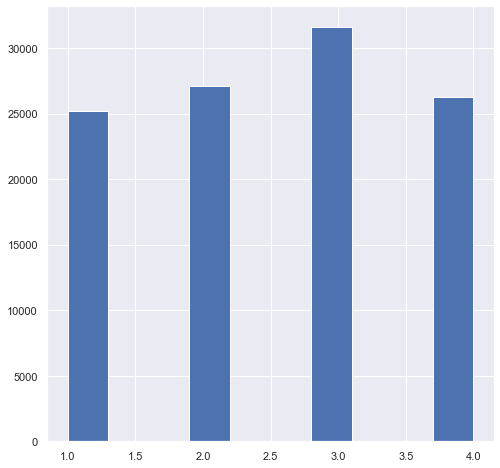

In [883]:
df_clients.app_date.hist()

### Рассмотрим и проанализируем колонку education

In [884]:
display(df_clients['education'].unique())
df_clients['education'].value_counts()

array(['GRD', 'SCH', 'UGR', 'PGR', nan, 'ACD'], dtype=object)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

<AxesSubplot:>

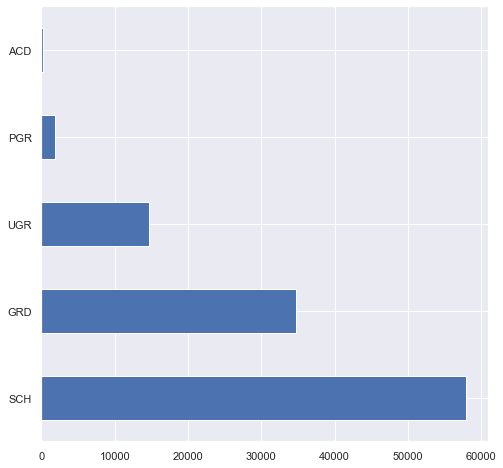

In [885]:
df_clients.education.value_counts().plot.barh()

Мы помним,что в этой колонке встречаются пропуски.

In [886]:
df_clients['education'].value_counts().index[0]

'SCH'

Самый часто втречающийся вариант - это SCH. Заполним им пропуски

In [887]:
df_clients['education'] = df_clients['education'].fillna(df_clients['education'].value_counts().index[0])

In [888]:
#Проверим, что пропусков больше нет.
df_clients.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

In [889]:
#Удалим пустые строки
#df_clients.dropna(inplace=True)

### Рассмотрим и проанализируем колонку home_address

In [890]:
display(df_clients['home_address'].unique())
df_clients['home_address'].value_counts()

array([1, 2, 3], dtype=int64)

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

<AxesSubplot:xlabel='home_address', ylabel='default'>

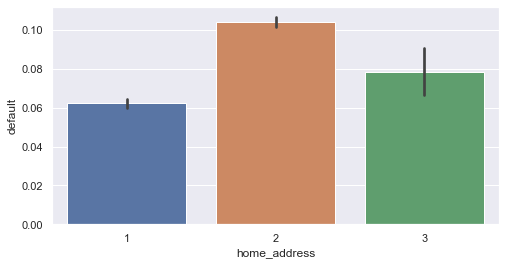

In [891]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.barplot(x= 'home_address', y = 'default', data = df_clients)

<AxesSubplot:>

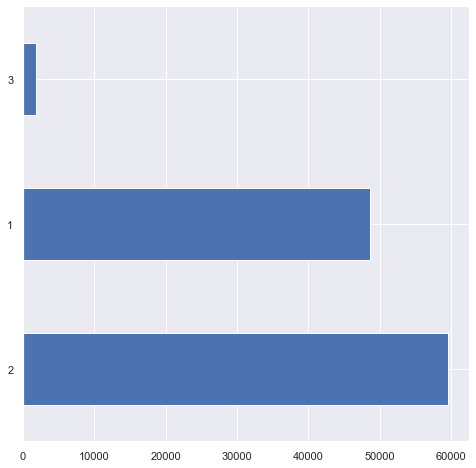

In [892]:
df_clients.home_address.value_counts().plot.barh()

<AxesSubplot:xlabel='home_address'>

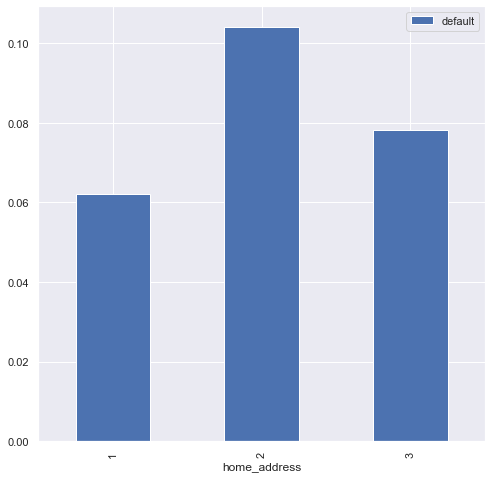

In [893]:
df_clients.pivot_table(values = ['default'], 
               index = 'home_address', 
               aggfunc = 'mean').plot(kind = 'bar')

### Рассмотрим и проанализируем колонку work_address

In [894]:
display(df_clients['work_address'].unique())
df_clients['work_address'].value_counts()

array([2, 3, 1], dtype=int64)

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

<AxesSubplot:>

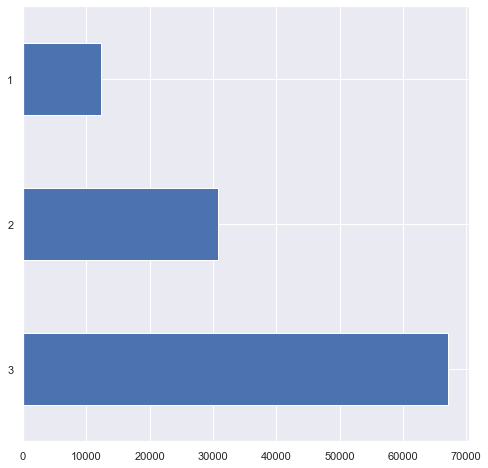

In [895]:
df_clients.work_address.value_counts().plot.barh()

<AxesSubplot:xlabel='work_address'>

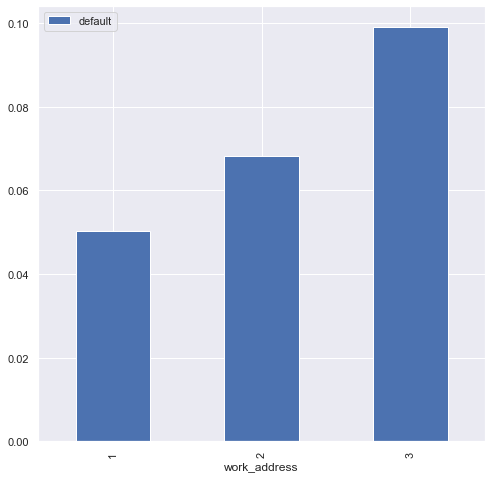

In [896]:
df_clients.pivot_table(values = ['default'], 
               index = 'work_address', 
               aggfunc = 'mean').plot(kind = 'bar')

### Рассмотрим и проанализируем колонку sna

In [897]:
#sna - связь заемщика с клиентами банка

In [898]:
display(df_clients['sna'].unique())
df_clients['sna'].value_counts()

array([1, 4, 2, 3], dtype=int64)

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа...

In [899]:
#для категориальных переменных применим OneHotEncoder
Сategor_perem = OneHotEncoder(sparse = False).fit_transform(df_clients[cat_cols].values)

In [900]:
Сategor_perem

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [901]:
#проверим преобразование
df_X = pd.DataFrame(data=Сategor_perem)
df_X.head()
# 15 столбцов = education      - 5 вариантов ('SCH', 'GRD', 'UGR', 'PGR', 'ACD') 
#               + home_address - 3 варианта ('1','2','3')
#               + work_address - 3 варианта ('1','2','3')
#               + sna          - 4 варианта ('1','2','3','4')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [902]:
#Добавим признаки
for i in range(19):
    df_clients[i] =df_X[i]

In [903]:
#проверим добавились ли
len(df_clients.columns)

39

## Рассмотрим и проанализируем бинарные переменные в колонках bin_cols

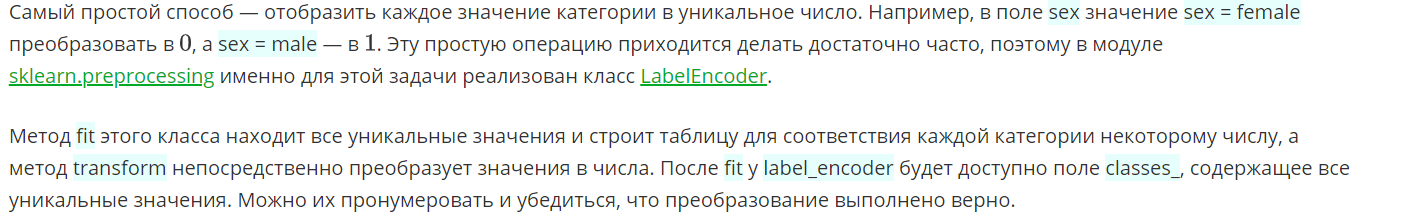

Применим LabelEncoder ко всему набору бинарных переменных.

In [904]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df_clients[column] = label_encoder.fit_transform(df_clients[column])

In [905]:
#и еще закодируем education из категориальных переменных
df_clients['education'] = label_encoder.fit_transform(df_clients['education'])

Почему мы применили метод только к бинарным переменным? Единственным минусом использования кодирования при помощи LabelEncoder() является то, что при использовании этого подхода мы должны быть уверены, что признак не может принимать неизвестных ранее значений. 

→ Что произойдет, если у нас появятся данные с другими категориями? LabelEncoder будет ругаться, что не знает новую категорию. 

Например, если у нас появится новый пол (помимо женского и мужского), признак sex придется обрабатывать по-другому.

Исходя из описания, наши признаки строго бинарные (принимают только два значения) и сюрпризов (новых неизвестных значений) быть не должно.

In [906]:
df_clients

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,9,10,11,12,13,14,15,16,17,18
0,74835,3,1,1,-0.889859,1,1,0.000000,0,-2.271884,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,17527,1,3,0,-0.021654,0,0,0.151515,0,-1.504999,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,75683,3,4,1,0.933372,1,1,0.000000,0,-1.691339,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,26883,2,3,1,1.454295,0,0,0.000000,0,-2.374182,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,28862,2,1,0,-0.108474,0,0,0.000000,0,-2.487502,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,3,1,0,0.499269,0,0,0.000000,0,-1.792064,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
110144,76821,3,3,1,0.151987,1,1,0.000000,0,-2.058029,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
110145,103695,4,3,1,-0.716218,0,0,0.000000,0,-1.512635,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
110146,861,1,3,0,-0.889859,0,0,0.000000,1,-1.479334,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<b>ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ И БИНАРНЫХ ПРИЗНАКОВ</b>

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

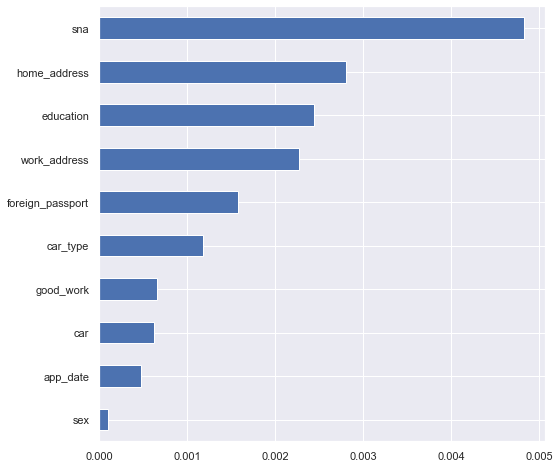

In [907]:
imp_cat = Series(mutual_info_classif(df_clients[bin_cols + cat_cols], df_clients['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<b>Cамый важный признак из категориальных - sna</b>

<AxesSubplot:>

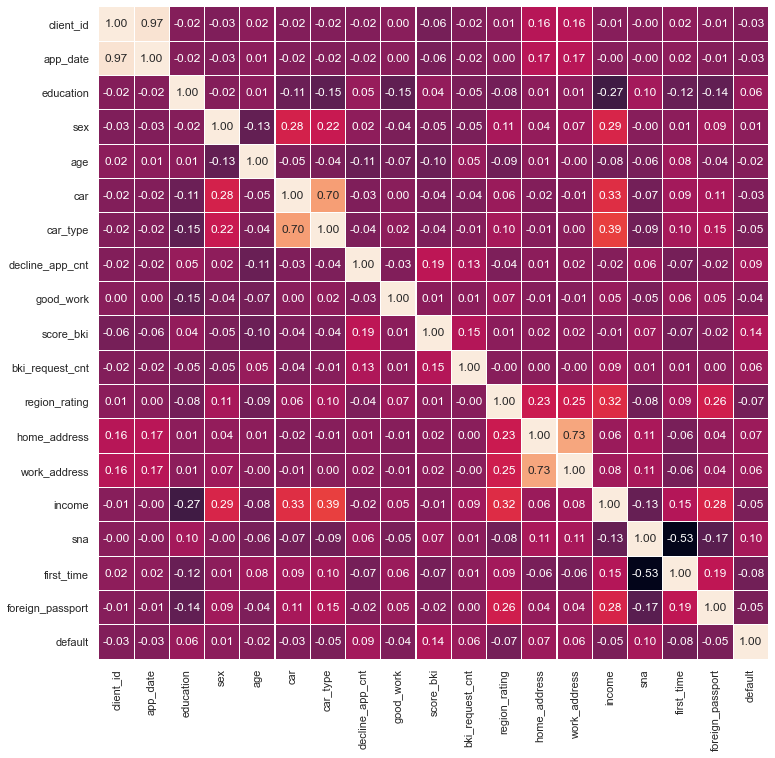

In [908]:
#уберу пока, чтоб ресурсы не ел
plt.rcParams['figure.figsize'] = (12,12)
sns.heatmap(df_clients.drop(['sample',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], axis=1).corr(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)


Сильная корреляция наблюдается между рабочим и домашним адресами - 0.73. А также между доходом и наличем загран.паспорта - 0,26

## Создание полиномиальных признаков

In [909]:
#Создадим признаки на основе двух хорошо скоррелированных колонок
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(df_clients[['income', 'foreign_passport']])
poly_features

array([[1.        , 0.5505618 , 0.        , 0.30311829, 0.        ,
        0.        ],
       [1.        , 0.04494382, 0.        , 0.00201995, 0.        ,
        0.        ],
       [1.        , 0.3258427 , 1.        , 0.10617346, 0.3258427 ,
        1.        ],
       ...,
       [1.        , 0.49438202, 0.        , 0.24441358, 0.        ,
        0.        ],
       [1.        , 0.13483146, 0.        , 0.01817952, 0.        ,
        0.        ],
       [1.        , 0.26966292, 0.        , 0.07271809, 0.        ,
        0.        ]])

In [910]:
df = pd.DataFrame(poly_features,
                  columns = ['poly1', 'poly2', 'poly3','poly4','poly5','poly6']                  )
display(df)

,poly1,poly2,poly3,poly4,poly5,poly6
0,1.0,0.550562,0.0,0.303118,0.000000,0.0
1,1.0,0.044944,0.0,0.002020,0.000000,0.0
2,1.0,0.325843,1.0,0.106173,0.325843,1.0
3,1.0,0.179775,0.0,0.032319,0.000000,0.0
4,1.0,1.000000,0.0,1.000000,0.000000,0.0
...,...,...,...,...,...,...
110143,1.0,0.179775,0.0,0.032319,0.000000,0.0
110144,1.0,0.775281,0.0,0.601060,0.000000,0.0
110145,1.0,0.494382,0.0,0.244414,0.000000,0.0
110146,1.0,0.134831,0.0,0.018180,0.000000,0.0


In [911]:
#Добавим наши признаки в наш дейтафрейм
df_clients['poly1'] =df['poly1']
df_clients['poly2'] =df['poly2']
df_clients['poly3'] =df['poly3']
df_clients['poly4'] =df['poly4']
df_clients['poly5'] =df['poly5']
df_clients['poly6'] =df['poly6']

In [912]:
for col in num_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки decline_app_cnt
Найдены статистически значимые различия для колонки bki_request_cnt
Найдены статистически значимые различия для колонки first_time


In [913]:
for col in cat_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки education
Найдены статистически значимые различия для колонки home_address
Найдены статистически значимые различия для колонки work_address
Найдены статистически значимые различия для колонки sna


In [914]:
for col in bin_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки car
Найдены статистически значимые различия для колонки car_type
Найдены статистически значимые различия для колонки good_work
Найдены статистически значимые различия для колонки foreign_passport


# Data Preprocessing

In [915]:
df_preproc = df_clients.copy()

In [916]:
# Теперь выделим часть для обучения модели (research) и финального предсказания (prediction)
research = df_preproc.query('sample == 1').drop(['sample'], axis=1)
prediction = df_preproc.query('sample == 0').drop(['sample'], axis=1)

In [917]:
################################################################################
#from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
#penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
#C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
#hyperparameters = dict(C=C, penalty=penalty)
################################################################################

In [918]:
# Разделим данные для обучения на тренировочную и валидационную части
X_research = research.drop(['default','client_id','income','app_date'],axis=1).values
y_research = research.default

X_train, X_val, y_train, y_val = train_test_split(X_research, y_research, test_size = 0.2, random_state=42)


# Обучаем модель
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

################################################################################
#добавлено
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
#clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

#best_model = clf.fit(X_train, y_train)

# View best hyperparameters
#print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
################################################################################

# Проверяем способность предсказания на данных из валидационной части
val_predicted = model.predict(X_val)
val_predicted_prob = model.predict_proba(X_val)

#val_predicted_prob = val_predicted_prob[:,1]


### Оценка качества модели

В качестве методов оценки прогностической способности модели используем ROC-анализ.
Классификатор имеет параметр порог отсечения. Изменяя его значение, мы получаем то или иное разбиение на два класса — класс с положительными исходами и класс с отрицательными исходами.

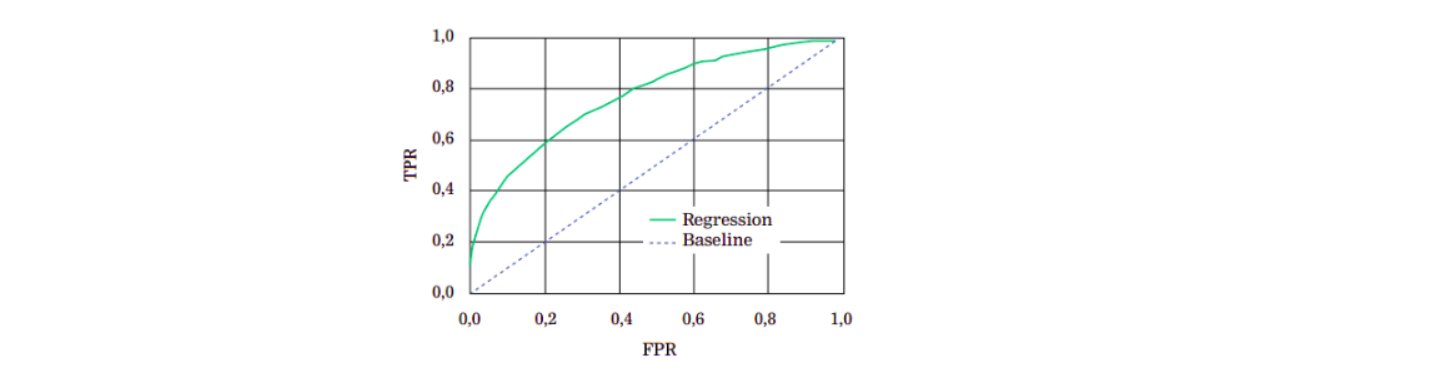

В нашем примере положительным исходом будет наличие дефолта у заемщика, отрицательным — отсутствие дефолта.

accuracy_score: 0.8745934959349594
precision_score: 0.3867924528301887
recall_score: 0.022441160372194856
f1_score: 0.04242110708742887

confusion matrix: 
 [[12868    65]
 [ 1786    41]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 65 
 или 0.5% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим кредит: 1786 
или 97.76% от всех не вернувших


roc_auc_score: 0.7419509271627749


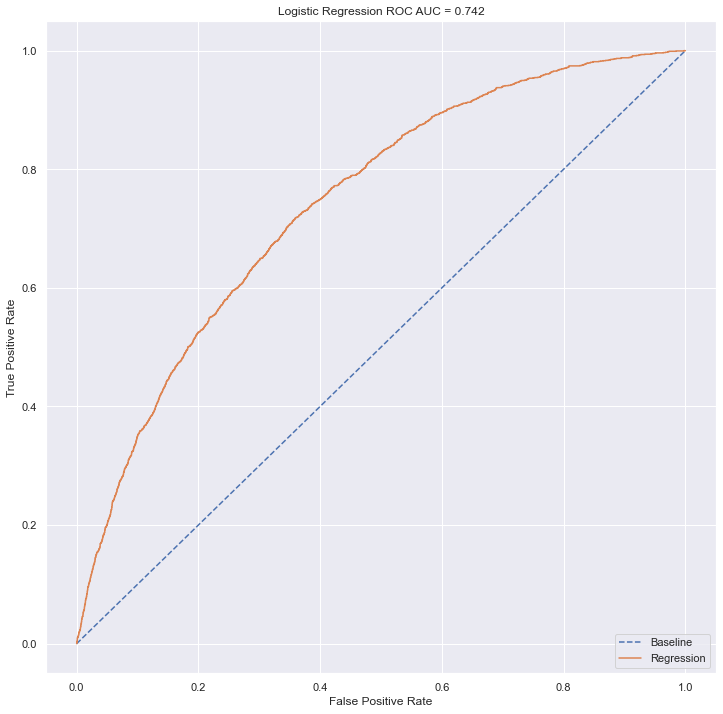

In [919]:
# # Выводим получившиеся метрики
print('accuracy_score:', accuracy_score(y_val, val_predicted))
print('precision_score:', precision_score(y_val, val_predicted))
print('recall_score:', recall_score(y_val, val_predicted))
print('f1_score:', f1_score(y_val, val_predicted))
сf_mtx = confusion_matrix(y_val, val_predicted)
print()
print('confusion matrix:', '\n', сf_mtx)
tn, fp, fn, tp = сf_mtx.ravel()
print()
print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
print('Предсказан возврат кредита клиентом, по факту не вернувшим кредит: {} \n\
или {}% от всех не вернувших\n'.format(fn, 
                                        round((1-recall_score(y_val,
                                                              val_predicted))*100, 2)))
print()
print('roc_auc_score:', roc_auc_score(y_val, val_predicted_prob[:, 1]))
fpr, tpr, threshold = roc_curve(y_val, val_predicted_prob[:, 1])
roc_auc = roc_auc_score(y_val, val_predicted_prob[:, 1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

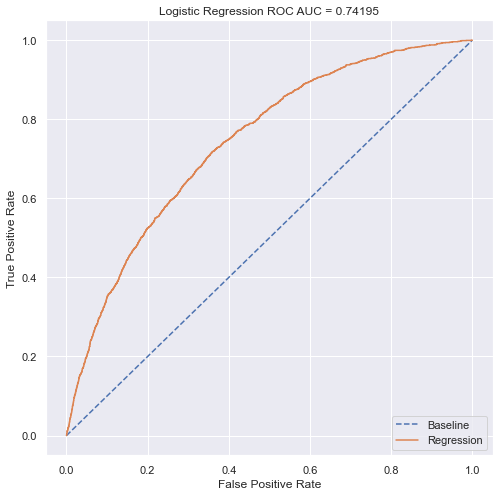

f1 score:= 0.0424
precision: 0.3868
recall: 0.0224
Confusion matrix:
[[12868    65]
 [ 1786    41]]


In [920]:
metrics(y_val, val_predicted_prob[:, 1], val_predicted)

In [921]:
# Предсказываем целевую переменную на данных из prediction
X_prediction = prediction.drop(['default','client_id','income','app_date'],axis=1).values
prediction_target = model.predict_proba(X_prediction)[:, 1]
submission = pd.concat([prediction.client_id,pd.Series(prediction_target,name='default')],axis=1)
submission.to_csv('submission.csv', index=False)
submission.shape

(36349, 2)

In [922]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  36349 non-null  int64  
 1   default    36349 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 851.9 KB


In [923]:
#0.53364
#0.67101
#0.66968
#0.73651
#0.73673 - с полиномиал. признаками из'income', 'foreign_passport'
#0.73974 c 18 столбцами onehotencoding
#0.73991 без income
#0.74195 без app_date

In [924]:
#submission = pd.DataFrame({'client_id': test_client_id,
#                              'default': y_pred_prob})
#submission.to_csv('submission.csv', index=False)
